Christian Erikson

Math 76 Homework 3

# Eigenbears

## Instructions

#### Part 1: Data preparation (ALREADY COMPLETED)
The folder that contains this notebook also contains a data set of pictures of pandas and brown bears. 
1. Load the images for train and test.
2. Reduce their size/resolution by 50%.
3. Convert the colors to grey scale.
4. Display a few of the images. 

#### Part 2: Singular value decomposition (FOR YOU TO COMPLETE)
1. Follow the steps in the eigenfaces tutorial from the UW databook [[link]](https://github.com/dynamicslab/databook_python/blob/master/CH01/CH01_SEC06_2_3_4.ipynb) to perform an SVD on the images.
2. Note that you will need to "center the data" before doing the SVD. Data centering means replacing each variable $X_i$ with a new variable $X_i'$ that is equal to $X_i$ minus $X_i$'s mean value. (Think carefully about whether you want to use the mean of train set, test set, or the full data set for this.)
3. Display the first four "eigenbears" (i.e., the images associated with the first four eigenvectors). Explain what you see.
4. The singular vectors are sometimes called "principal components". Principal component analysis (PCA) is a data analysis method for which one projects high-dimensional data into the subspace of the first two singular vectors. Use the code scaffold provided below do perform PCA for the bears data. What do you notice?

#### Part 3: Non-parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Build a $k$-nearest-neighbors model with the train set, and test its accuracy on the test set. (ALREADY COMPLETE)
2. Try different values of $k$ between 1 and 15. For what value do you get the best test accuracy? (FOR YOU TO COMPLETE)
3. Which bears seem to be hard to classify? Display them.
4. What might make them hard to classify?

#### Part 4: Parametric supervised classification (PARTIALLY FOR YOU TO COMPLETE)
1. Try using logistic regression and LDA to classify the bears. 
2. What method gives you the best test accuracy? 
3. How does the result compare to the non-parametric classification?
4. One can use the absolute values of the regression coefficients to see which pixels have the greatest influence on the prediction of the logistic regression. Retrieving the coefficients $\beta_i$ for each pixel $X_i$ and displaying them as an image creates a "bear mask". This notebook includes code for creating that bear mask. Take a look at the bear mask and explain what you see.

#### Part 5: Robustness to additive white noise  (FOR YOU TO RUN AND COMMENT ON)
1. Rerun the code with `add_noise` set to True. The images of the bears should now be very noisy.
2. How does the additive noise affect the test accuracy of the various models and why?
3. How does additive noise affect the eigenbears and the bear mask?
4. Can you think of other types of noise that might affect the classification results differently?

--------------------------------

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os, time

## Part 1: Data preparation

In [2]:
# toggle settings
add_noise = False

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


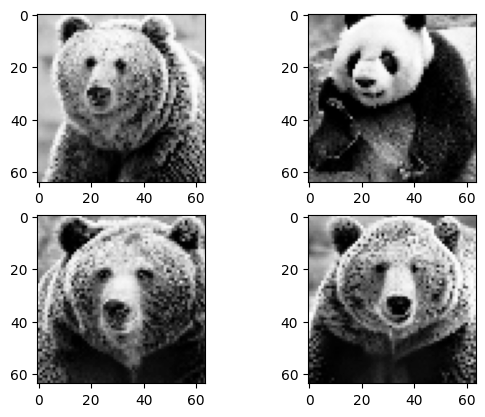

In [3]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

# Part 2: Singular value decomposition

In [13]:
# Construct data matrix of centered data
train_flat = [img.flatten() for img in train_images] # Flatten data to convert 2D array to 1D array
data_matrix = np.array(train_flat).T  # Transpose to get features as rows and images as columns

# Compute average 
avg_face = np.mean(data_matrix, axis=1)

# Subtract mean. Restrcited to training dataset since using the test dataset would artificially decrease the error.
A = data_matrix - avg_face[:, np.newaxis]

U, S, Vh = np.linalg.svd(A)

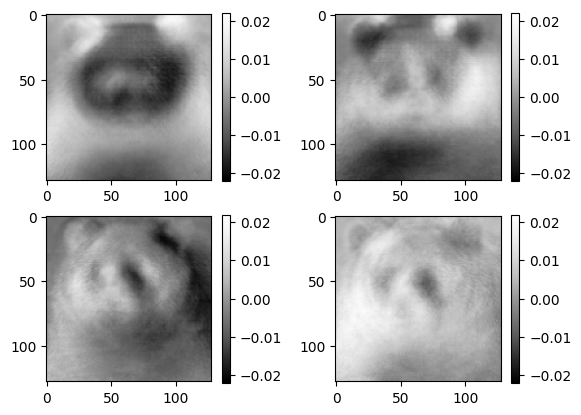

In [14]:
# show the first four eigenbears
for i in range(4):
    plt.subplot(2,2,1+i)
    plt.imshow((U[:,i]).reshape((128,128)), cmap='Greys_r',
        # force colormap to be the same for all four
        vmin=-np.max(np.abs(U[:,:4])),
        vmax=np.max(np.abs(U[:,:4])))
    plt.colorbar()
plt.subplots_adjust(wspace=0.4)

The first four images, three of which appear to be pandas, have been simplified to the most prominent features using the SVD. The ears and eyes seem to be emphasized.

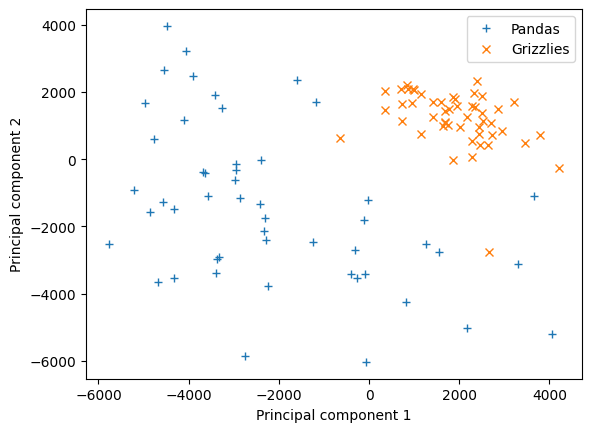

In [16]:
# Clustering of panda bears and brown bears along the first and second principal component
# indices of pandas in the test set
indices_pandas = range(50)
# indices of brown bears in the test set
indices_brownbears = range(50,100)

for i, indices in enumerate([indices_pandas, indices_brownbears]):
    # get projections of data onto principal component 1
    p1 = [np.dot(U[:,0],np.ravel(test_images[x].flatten() - avg_face)) for x in indices]
    # get projections of data onto principal component 2
    p2 = [np.dot(U[:,1],np.ravel(test_images[x].flatten() - avg_face)) for x in indices]
    plt.plot(p1, p2, marker='+x'[i], lw=0, label=['Pandas', 'Grizzlies'][i])

# annotate axes
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
# add legend
plt.legend()

There is a clear seperation along principal component 1, where grizzlies tend to have higher values. There is also less variance in the grizzly cluster overall.

# Part 3: Nonparametric classification

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# construct response variable: Train set was created by appending 250 pandas
# and THEN 250 brown bears to the list of training images. We code pandas as
# '0' and brown bears as '1'.
y_train =  np.concatenate([np.zeros(250), np.ones(250)])

# Test set was created by appending 50 pandas and THEN 50 brown bears to the 
# list of test images. We code pandas as '0' and brown bears as '1'.
y_test = np.concatenate([np.zeros(50), np.ones(50)])

In [26]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(A.T, y_train)
    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      9 	| [ 2  4  5  6 29 32 34 42 45]
    2	|      6 	| [ 4  5 29 32 34 42]
    3	|      10 	| [ 2  4  5  6 17 29 32 34 42 45]
    4	|      8 	| [ 4  6 17 29 32 34 42 45]
    5	|      9 	| [ 4  5  6 17 29 32 34 42 45]
    6	|      5 	| [ 4 17 29 34 42]
    7	|      8 	| [ 4  5  6 17 29 34 42 45]
    8	|      6 	| [ 4  6 29 34 42 45]
    9	|      8 	| [ 4  5  6 17 29 34 42 45]
    10	|      7 	| [ 4  6 17 29 34 42 45]
    11	|      8 	| [ 4  5  6 17 29 34 42 45]
    12	|      6 	| [ 6 17 29 34 42 45]
    13	|      7 	| [ 4  6 17 29 34 42 45]
    14	|      7 	| [ 4  6 17 29 34 42 45]
    15	|      7 	| [ 4  6 17 29 34 42 45]


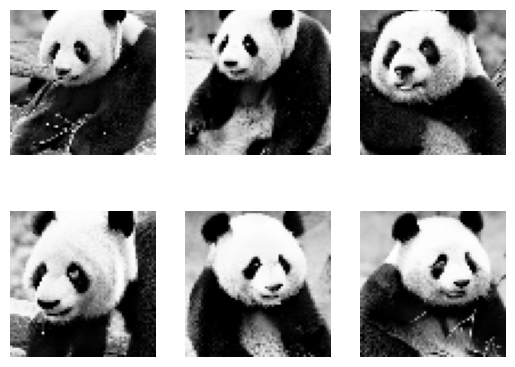

In [48]:
# Show hard-to-classify bears
list = [3,5,28,33,41,44]

fig, axes = plt.subplots(2, 3)

for ax, idx in zip(axes.flatten(), list):
    ax.imshow(train_images[idx][::2, ::2], cmap='Greys_r')
    ax.axis('off')  # Hide the axis

The images that tend to be frequently missclassified are pandas with thier head at an angle. The angling of the head makes thier snout look more elongate than in an image looking striaght on. The enlogated snout increases the similarity to the grizzlies, which have this feature regularly.

# Part 4: Parametric classification

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [60]:
from sklearn.model_selection import cross_val_score, GridSearchCV

# Logistic Regression with Cross-Validation
logistic_model = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.001, 0.005, 0.01, 0.02]} 
grid_search = GridSearchCV(logistic_model, param_grid, cv=5)
grid_search.fit(A.T, y_train)
best_logistic_model = grid_search.best_estimator_

# Using best model
logistic_predictions = best_logistic_model.predict(A_test.T)

# Misclassifications
logistic_errors = np.abs(logistic_predictions - y_test)

print('Logistic Regression Classification with Cross-Validation')
print('Best Parameters:', grid_search.best_params_)
print('Total errors:', int(np.sum(logistic_errors)))
print('Misclassified indices:', (np.argwhere(logistic_errors).T)[0])


Logistic Regression Classification with Cross-Validation
Best Parameters: {'C': 0.01}
Total errors: 32
Misclassified indices: [ 4  5  8 10 11 12 17 18 20 25 29 30 35 38 40 41 42 51 54 55 59 61 71 72
 76 81 82 85 91 92 96 98]


In [57]:
# LDA with Cross-Validation
lda_model = LinearDiscriminantAnalysis()
scores = cross_val_score(lda_model, A.T, y_train, cv=10)
lda_model.fit(A.T, y_train)

# Use model to make predictions on the test set
lda_predictions = lda_model.predict(A_test.T)

# Detect misclassifications
lda_errors = np.abs(lda_predictions - y_test)

# Print results
print('LDA Classification with Cross-Validation')
print('Cross-validation scores:', scores)
print('Total errors:', int(np.sum(lda_errors)))
print('Misclassified indices:', (np.argwhere(lda_errors).T)[0])


LDA Classification with Cross-Validation
Cross-validation scores: [1.   1.   0.98 1.   1.   0.98 1.   1.   0.98 0.96]
Mean CV score: 0.9899999999999999
Total errors: 14
Misclassified indices: [ 4  5  6 10 12 17 29 35 42 51 61 69 72 82]


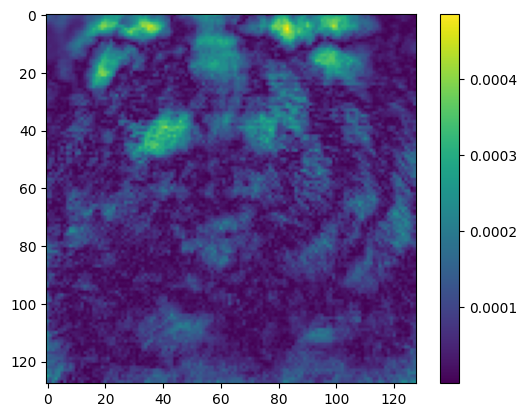

In [62]:
# Construct the bear mask:
# Show absolute value of logistic-regression coefficients for each pixel
plt.imshow(np.abs((best_logistic_model.coef_).reshape((128,128))))
plt.colorbar()

Linear discriminant analysis outperfoms logisitc regression, however neither is better than the non-parmametric method. The bearmask highlights the eyes and ears, similar to what can be seen in the results of the singluar value decomposition.

<h3>Part 5</h3>

In [63]:
# toggle settings
add_noise = True

# Initiliaze lists for image collection
train_images = []
test_images = []

for i, images in enumerate([train_images, test_images]):

    # set paths to images of pandas and bears in train and test set
    datasetname = ['Train','Test'][i]
    folder_path1 = 'PandasBears/{}/Pandas/'.format(datasetname)
    folder_path2 = 'PandasBears/{}/Bears/'.format(datasetname)
    

    for folder_path in [folder_path1, folder_path2]:

        # print the name of the folder that is currently being processed
        print(folder_path, end=' ')
        
        # go through all files in the folder
        file_count = 0
        for filename in os.listdir(folder_path):
            
            # find the files that are JPEGs
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):

                # add 1 to the file count
                file_count += 1
                
                # Construct full file path
                file_path = os.path.join(folder_path, filename)
    
                # import image
                image = plt.imread(file_path, format='jpeg')
    
                # convert to gray scale
                image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
                # decrease image size by 50%
                image = image[::2,::2]

                if add_noise:
                    # add some noise
                    image = image + np.random.normal(scale=100, size=image.shape)
    
                # add the new image to collection
                images.append(image)

        print('has {} images'.format(file_count))

PandasBears/Train/Pandas/ has 250 images
PandasBears/Train/Bears/ has 250 images
PandasBears/Test/Pandas/ has 50 images
PandasBears/Test/Bears/ has 50 images


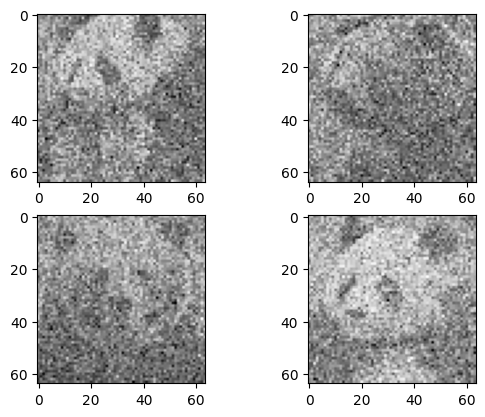

In [64]:
# look at 4 random bears
for i0, i in enumerate(np.random.randint(0, 500, size=4)):
    plt.subplot(2,2,1+i0)
    plt.imshow(train_images[i][::2,::2],cmap='Greys_r')

In [65]:
# Construct data matrix of centered data
train_flat = [img.flatten() for img in train_images] # Flatten data to convert 2D array to 1D array
data_matrix = np.array(train_flat).T  # Transpose to get features as rows and images as columns

# Compute average 
avg_face = np.mean(data_matrix, axis=1)

# Subtract mean. Restrcited to training dataset since using the test dataset would artificially decrease the error.
A = data_matrix - avg_face[:, np.newaxis]

U, S, Vh = np.linalg.svd(A)

In [66]:
print('   k\t|  # errors\t| misclassified bears')
print('--------------------------------------------')
for k in range(1,16):
    # fit KNN model
    modelKN = KNeighborsClassifier(n_neighbors=k).fit(A.T, y_train)
    # use model to make predictions on the test set
    predictions = [modelKN.predict([np.ravel(test_images[i])]) for i in range(len(y_test))]
    # detect misclassifications
    errors = np.abs((np.array(predictions).T)[0]-y_test)
    # print results to table
    print('    {}\t|      {} \t| {}'.format(k, int(np.sum(errors)), (np.argwhere(errors).T)[0]))

   k	|  # errors	| misclassified bears
--------------------------------------------
    1	|      9 	| [ 2  4  5  6 29 32 34 42 45]
    2	|      6 	| [ 4  5 29 32 34 42]
    3	|      9 	| [ 4  5  6 17 29 32 34 42 45]
    4	|      8 	| [ 4  6 17 29 32 34 42 45]
    5	|      9 	| [ 4  5  6 17 29 32 34 42 45]
    6	|      7 	| [ 4  5  6 29 32 34 42]
    7	|      9 	| [ 4  5  6 17 29 32 34 42 48]
    8	|      7 	| [ 4  5  6 17 29 34 42]
    9	|      7 	| [ 4  5  6 17 29 34 42]
    10	|      6 	| [ 4  6 17 29 34 42]
    11	|      8 	| [ 4  5  6 17 29 34 42 45]
    12	|      7 	| [ 4  6 17 29 34 42 45]
    13	|      7 	| [ 4  6 17 29 34 42 45]
    14	|      7 	| [ 4  6 17 29 34 42 45]
    15	|      7 	| [ 4  6 17 29 34 42 45]


In [67]:
# Logistic Regression with Cross-Validation
logistic_model = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.001, 0.005, 0.01, 0.02]} 
grid_search = GridSearchCV(logistic_model, param_grid, cv=5)
grid_search.fit(A.T, y_train)
best_logistic_model = grid_search.best_estimator_

# Using best model
logistic_predictions = best_logistic_model.predict(A_test.T)

# Misclassifications
logistic_errors = np.abs(logistic_predictions - y_test)

print('Logistic Regression Classification with Cross-Validation')
print('Best Parameters:', grid_search.best_params_)
print('Total errors:', int(np.sum(logistic_errors)))
print('Misclassified indices:', (np.argwhere(logistic_errors).T)[0])

Logistic Regression Classification with Cross-Validation
Best Parameters: {'C': 0.001}
Total errors: 22
Misclassified indices: [ 4  8 11 17 20 29 30 38 42 48 51 52 55 59 70 71 72 76 81 85 92 98]


In [68]:
# LDA with Cross-Validation
lda_model = LinearDiscriminantAnalysis()
scores = cross_val_score(lda_model, A.T, y_train, cv=10)
lda_model.fit(A.T, y_train)

# Use model to make predictions on the test set
lda_predictions = lda_model.predict(A_test.T)

# Detect misclassifications
lda_errors = np.abs(lda_predictions - y_test)

# Print results
print('LDA Classification with Cross-Validation')
print('Cross-validation scores:', scores)
print('Total errors:', int(np.sum(lda_errors)))
print('Misclassified indices:', (np.argwhere(lda_errors).T)[0])

LDA Classification with Cross-Validation
Cross-validation scores: [0.98 0.98 0.94 1.   1.   0.92 1.   1.   0.96 0.98]
Total errors: 53
Misclassified indices: [ 1  3  4  8  9 10 11 12 13 15 17 18 19 20 21 23 25 29 30 32 33 35 37 38
 40 41 42 45 46 48 50 51 53 55 57 59 60 62 63 66 69 71 76 81 82 83 86 88
 89 91 95 96 98]


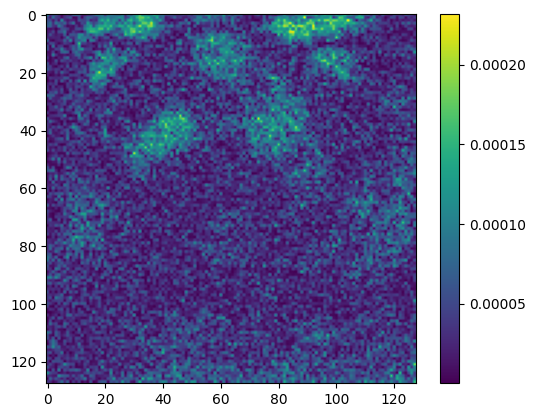

In [69]:
plt.imshow(np.abs((best_logistic_model.coef_).reshape((128,128))))
plt.colorbar()

With noise added, k-nearest neighbors performed similarly, perhaps slighly better. Logisitic regression results improved, while LDA results became much worse. In examining the bear mask, many of the details, such as around the mouth are lost, however, the other features become even more prominent. The ears, for example, are even more emphasized by the contrast of very limited structure elsewhere. The less substantial role of the mouth may be why their was improvement in some of the models, since it seemed like the mouth was a problem forthe classifier originally. Using a non-gaussian distribution may not affect the classifiers in the same way. For example, noise was added from a gamma distribution, dark pixels may end up modified more than light pixels. If this were the case, the eyes of the panda would be less distinct and may make it more difficult for the classifier to distinguish between the bears.